Breast cancer classifiction of malignant vs benign tumors  
Ran through a few sklearn classifiers, and one simple NN model.  
All models generally performed well in the high 90s.  
Confusion Matrix, and Classifications reports listed in this notebook.  
At the bottom there is a deeper dive into what was being called incorrectly in the NN model.  
A false negative was called and is highlighted in red to understand why.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/breast-cancer-wisconsin-diagnostic-dataset/brca.csv


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow import keras

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
import seaborn as sns

In [5]:
df = pd.read_csv("/kaggle/input/breast-cancer-wisconsin-diagnostic-dataset/brca.csv")

In [6]:
df

,Unnamed: 0,x.radius_mean,x.texture_mean,x.perimeter_mean,x.area_mean,x.smoothness_mean,x.compactness_mean,x.concavity_mean,x.concave_pts_mean,x.symmetry_mean,...,x.texture_worst,x.perimeter_worst,x.area_worst,x.smoothness_worst,x.compactness_worst,x.concavity_worst,x.concave_pts_worst,x.symmetry_worst,x.fractal_dim_worst,y
0,1,13.540,14.36,87.46,566.3,0.09779,0.08129,0.06664,0.047810,0.1885,...,19.26,99.70,711.2,0.14400,0.17730,0.23900,0.12880,0.2977,0.07259,B
1,2,13.080,15.71,85.63,520.0,0.10750,0.12700,0.04568,0.031100,0.1967,...,20.49,96.09,630.5,0.13120,0.27760,0.18900,0.07283,0.3184,0.08183,B
2,3,9.504,12.44,60.34,273.9,0.10240,0.06492,0.02956,0.020760,0.1815,...,15.66,65.13,314.9,0.13240,0.11480,0.08867,0.06227,0.2450,0.07773,B
3,4,13.030,18.42,82.61,523.8,0.08983,0.03766,0.02562,0.029230,0.1467,...,22.81,84.46,545.9,0.09701,0.04619,0.04833,0.05013,0.1987,0.06169,B
4,5,8.196,16.84,51.71,201.9,0.08600,0.05943,0.01588,0.005917,0.1769,...,21.96,57.26,242.2,0.12970,0.13570,0.06880,0.02564,0.3105,0.07409,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,565,20.920,25.09,143.00,1347.0,0.10990,0.22360,0.31740,0.147400,0.2149,...,29.41,179.10,1819.0,0.14070,0.41860,0.65990,0.25420,0.2929,0.09873,M
565,566,21.560,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.138900,0.1726,...,26.40,166.10,2027.0,0.14100,0.21130,0.41070,0.22160,0.2060,0.07115,M
566,567,20.130,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.097910,0.1752,...,38.25,155.00,1731.0,0.11660,0.19220,0.32150,0.16280,0.2572,0.06637,M
567,568,16.600,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.053020,0.1590,...,34.12,126.70,1124.0,0.11390,0.30940,0.34030,0.14180,0.2218,0.07820,M


In [7]:
df = df.drop(columns="Unnamed: 0")

In [8]:
def encode_target(y):
    if y == "B":
        return 0
    if y == "M":
        return 1

In [9]:
df["y"] = df["y"].apply(lambda x: encode_target(x))

In [10]:
y = df["y"]
X = df.drop(columns="y")

In [11]:
X=(X-X.min())/(X.max()-X.min())

Crossing columns to try and get more data

In [12]:
X.iloc[:,0] * X.iloc[:,1]
col = X.columns
d = {}
for a in range(0, len(col)):
    for b in range(a+1, len(col)):
        d[X.columns[a]+X.columns[b]] = X.iloc[:,a] * X.iloc[:,b]

In [13]:
X = pd.concat([X, pd.DataFrame(d)], axis=1)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13)

In [15]:
random_forest_clf = RandomForestClassifier()
kn_clf = KNeighborsClassifier()
lr_clf = LogisticRegression()
nb_clf = GaussianNB()
svc_clf = SVC()
models = [random_forest_clf, kn_clf, lr_clf, nb_clf, svc_clf]

All models generally perform well, with RandomForest, LogisticRegression, and SVC performing best.

In [16]:
for clf in models:
    print(clf)
    scores = cross_val_score(clf, X, y)
    mean = scores.mean()
    print("Cross Validation Scores")
    print(scores)
    print(mean)
    print()

RandomForestClassifier()
Cross Validation Scores
[0.93859649 0.96491228 0.99122807 0.96491228 0.99115044]
0.9701599130569786

KNeighborsClassifier()
Cross Validation Scores
[0.96491228 0.95614035 0.99122807 0.95614035 0.96460177]
0.9666045645086168

LogisticRegression()
Cross Validation Scores
[0.97368421 0.98245614 0.98245614 0.96491228 0.97345133]
0.9753920198726906

GaussianNB()
Cross Validation Scores
[0.89473684 0.93859649 0.95614035 0.94736842 0.9380531 ]
0.934979040521658

SVC()
Cross Validation Scores
[0.96491228 0.97368421 0.98245614 0.96491228 0.98230088]
0.9736531594472908



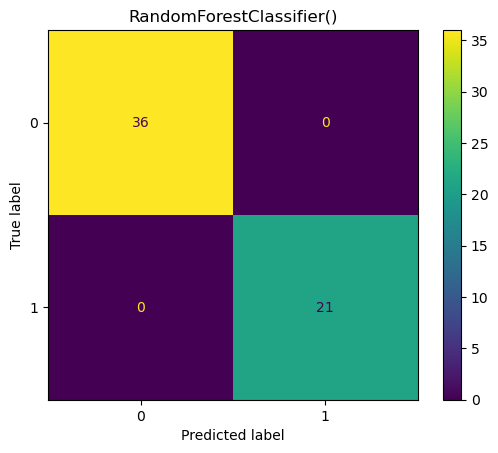

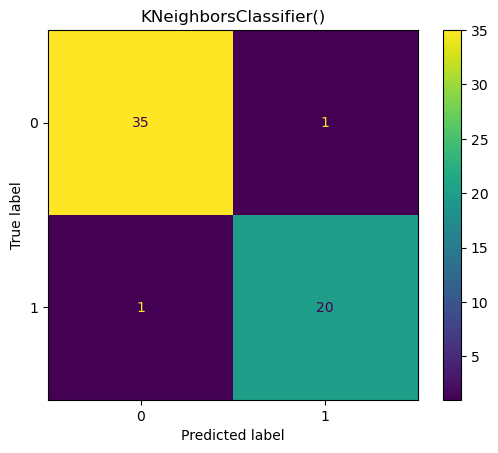

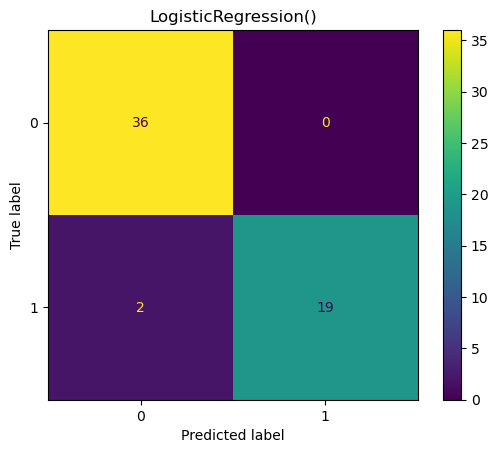

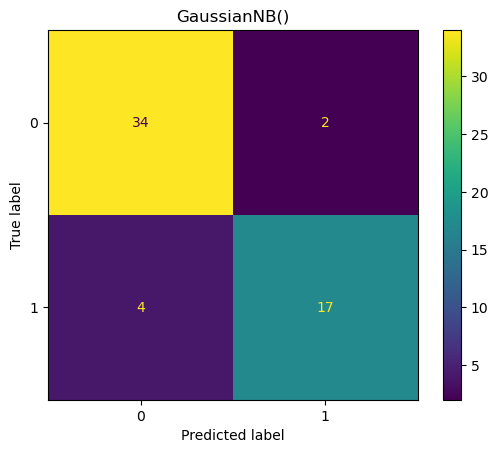

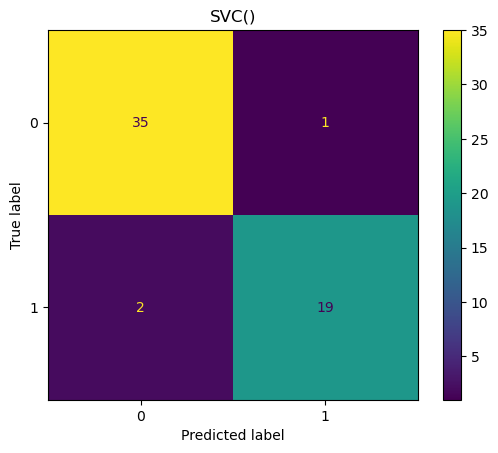

In [17]:
for clf in models:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred,labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    disp.ax_.set_title(clf)
    plt.show()

In [18]:
for clf in models:
    clf.fit(X_train, y_train)
    print(clf)
    y_pred = clf.predict(X_test)
    report = classification_report(y_test,y_pred)
    print(report)

RandomForestClassifier()
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        21

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57

KNeighborsClassifier()
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        36
           1       0.95      0.95      0.95        21

    accuracy                           0.96        57
   macro avg       0.96      0.96      0.96        57
weighted avg       0.96      0.96      0.96        57

LogisticRegression()
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        36
           1       1.00      0.90      0.95        21

    accuracy                           0.96        57
   macro avg       0.97      0.95      0.96        57
weigh

Simple NN

In [19]:
inputs = keras.Input(shape=(465,))
x = layers.Dense(128, activation="relu")(inputs)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="brca_model")

In [20]:
model.summary()

Model: "brca_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 465)]             0         
                                                                 
 dense (Dense)               (None, 128)               59648     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0

In [21]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=["accuracy"],
)

In [22]:
model.fit(X_train, y_train, batch_size=32, epochs=25, validation_data=(X_test,y_test))

Epoch 1/25
16/16 [==============================] - 1s 17ms/step - loss: 0.5922 - accuracy: 0.7930 - val_loss: 0.4012 - val_accuracy: 0.8596
Epoch 2/25
16/16 [==============================] - 0s 4ms/step - loss: 0.2697 - accuracy: 0.9238 - val_loss: 0.1871 - val_accuracy: 0.9123
Epoch 3/25
16/16 [==============================] - 0s 4ms/step - loss: 0.1638 - accuracy: 0.9395 - val_loss: 0.1131 - val_accuracy: 0.9298
Epoch 4/25
16/16 [==============================] - 0s 4ms/step - loss: 0.1148 - accuracy: 0.9590 - val_loss: 0.0779 - val_accuracy: 0.9825
Epoch 5/25
16/16 [==============================] - 0s 4ms/step - loss: 0.0925 - accuracy: 0.9609 - val_loss: 0.0941 - val_accuracy: 0.9298
Epoch 6/25
16/16 [==============================] - 0s 4ms/step - loss: 0.1354 - accuracy: 0.9473 - val_loss: 0.1841 - val_accuracy: 0.9298
Epoch 7/25
16/16 [==============================] - 0s 4ms/step - loss: 0.0963 - accuracy: 0.9590 - val_loss: 0.0617 - val_accuracy: 0.9649
Epoch 8/25
16/16 [=

In [23]:
y_pred = np.rint(model.predict(X_test))
y_pred_sig = model.predict(X_test)

2/2 [==============================] - 0s 3ms/step


NN performs about as well as earlier models

In [24]:
rep = classification_report(y_test, y_pred)
print(rep)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        36
           1       1.00      0.95      0.98        21

    accuracy                           0.98        57
   macro avg       0.99      0.98      0.98        57
weighted avg       0.98      0.98      0.98        57



Investigation on incorrect values

In [25]:
y_pred = y_pred.flatten()
y_pred_sig = y_pred_sig.flatten()

In [26]:
y_pred = pd.DataFrame(y_pred).set_index(y_test.index)
y_pred_sig = pd.DataFrame(y_pred_sig).set_index(y_test.index)

In [27]:
predict_df = pd.concat((pd.DataFrame(y_test), y_pred), axis=1)
predict_df = predict_df.rename(columns={0:"predict"})

In [28]:
predict_df = pd.concat((pd.DataFrame(predict_df), y_pred_sig), axis=1)
predict_df = predict_df.rename(columns={0:"predict_sig"})

In [29]:
predict_df["predict"] = predict_df["predict"].astype(int)

In [30]:
predict_df[predict_df["y"]!=predict_df["predict"]]

,y,predict,predict_sig
485,1,0,0.448804


In [31]:
predict_df = pd.concat([X_test, predict_df], axis=1)

In [32]:
predict_df["prediction_status"] = ["Wrong" if row["y"] != row["predict"] else "Right" for index, row in predict_df.iterrows()]

In [33]:
predict_df.head()

,x.radius_mean,x.texture_mean,x.perimeter_mean,x.area_mean,x.smoothness_mean,x.compactness_mean,x.concavity_mean,x.concave_pts_mean,x.symmetry_mean,x.fractal_dim_mean,...,x.concavity_worstx.concave_pts_worst,x.concavity_worstx.symmetry_worst,x.concavity_worstx.fractal_dim_worst,x.concave_pts_worstx.symmetry_worst,x.concave_pts_worstx.fractal_dim_worst,x.symmetry_worstx.fractal_dim_worst,y,predict,predict_sig,prediction_status
215,0.298121,0.135610,0.290236,0.168950,0.279859,0.203576,0.118955,0.142346,0.281313,0.125948,...,0.072159,0.052840,0.027267,0.072763,0.037547,0.027495,0,0,0.001396,Right
322,0.075252,0.114643,0.074217,0.033001,0.460143,0.174652,0.060098,0.075050,0.312121,0.448610,...,0.040979,0.039159,0.045816,0.081762,0.095661,0.091413,0,0,0.000071,Right
419,0.382365,0.342239,0.390505,0.238431,0.462851,0.416907,0.398313,0.438121,0.401515,0.271272,...,0.302042,0.103955,0.074414,0.181808,0.130144,0.044792,1,1,0.999781,Right
44,0.344503,0.336152,0.373437,0.206320,0.232373,0.625483,0.703608,0.387575,0.325253,0.584035,...,0.280195,0.088961,0.188906,0.084923,0.180332,0.057254,0,0,0.191808,Right
289,0.213403,0.165032,0.208693,0.110880,0.469170,0.192933,0.124367,0.097863,0.363131,0.332350,...,0.052949,0.056241,0.049994,0.069264,0.061571,0.065399,0,0,0.000376,Right


Incorrect rows below

In [34]:
predict_df[predict_df["prediction_status"] =="Wrong"]

,x.radius_mean,x.texture_mean,x.perimeter_mean,x.area_mean,x.smoothness_mean,x.compactness_mean,x.concavity_mean,x.concave_pts_mean,x.symmetry_mean,x.fractal_dim_mean,...,x.concavity_worstx.concave_pts_worst,x.concavity_worstx.symmetry_worst,x.concavity_worstx.fractal_dim_worst,x.concave_pts_worstx.symmetry_worst,x.concave_pts_worstx.fractal_dim_worst,x.symmetry_worstx.fractal_dim_worst,y,predict,predict_sig,prediction_status
485,0.330304,0.248225,0.32921,0.194655,0.514309,0.332863,0.229358,0.260736,0.428283,0.238837,...,0.121021,0.075938,0.041239,0.13989,0.075969,0.047669,1,0,0.448804,Wrong


Incorrect prediction data, predict_sig is the % the model thinks is positive

In [35]:
predict_df[predict_df["prediction_status"] =="Wrong"][['y','predict','predict_sig','prediction_status']]

,y,predict,predict_sig,prediction_status
485,1,0,0.448804,Wrong


Red points indicate incorrect calls.

/tmp/ipykernel_20/3855521413.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(figsize=(5,5))


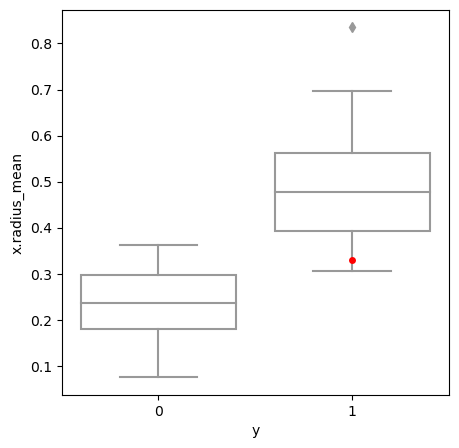

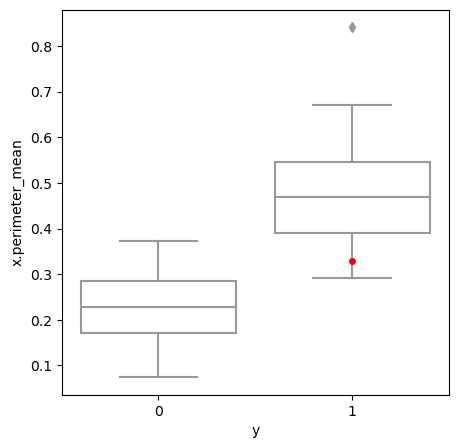

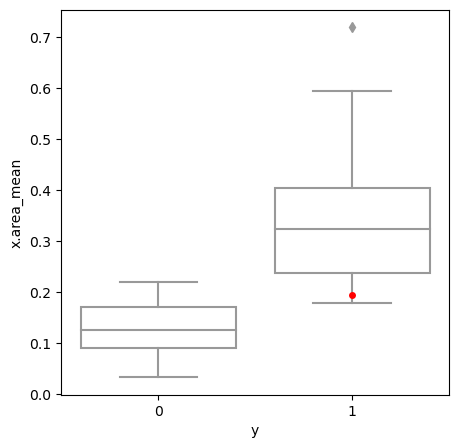

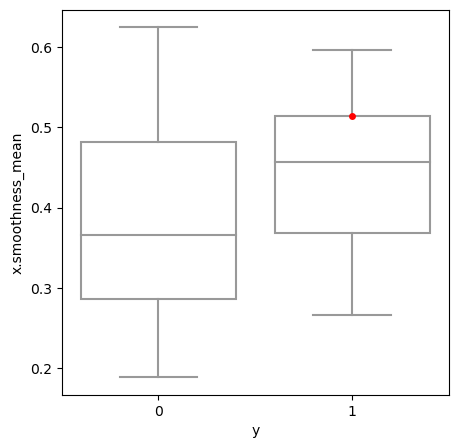

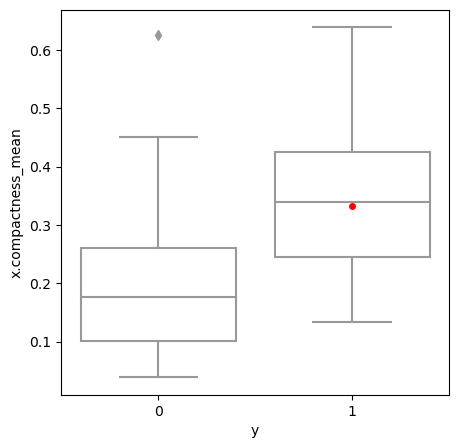

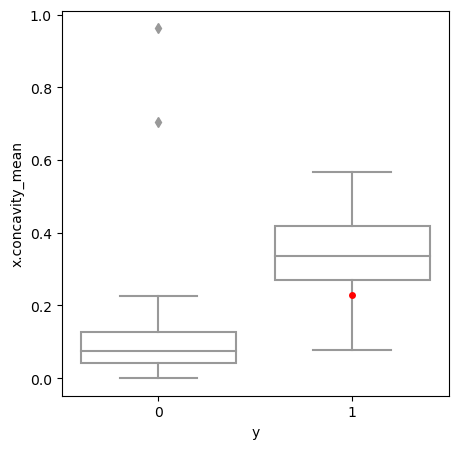

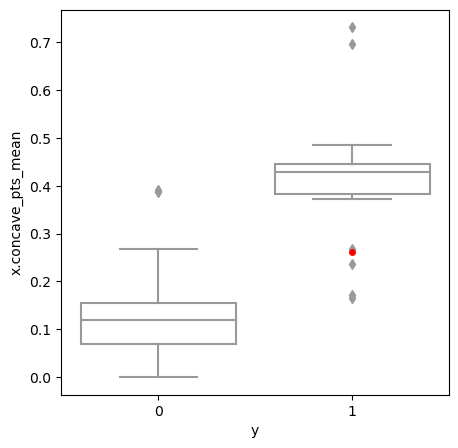

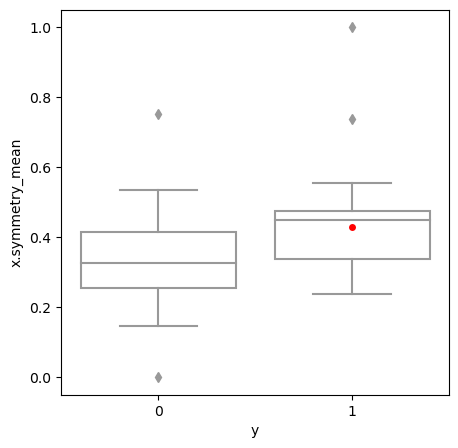

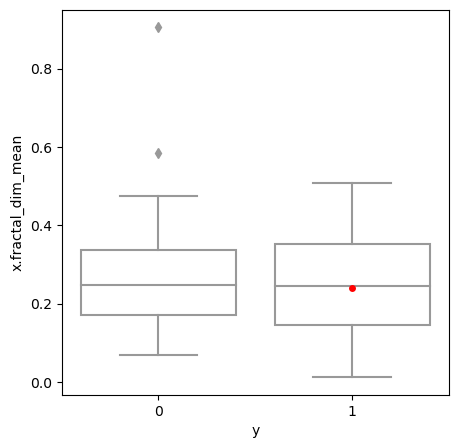

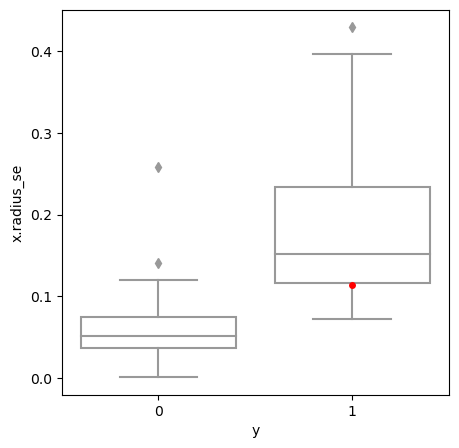

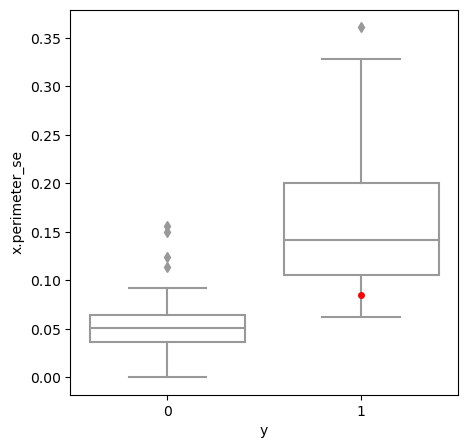

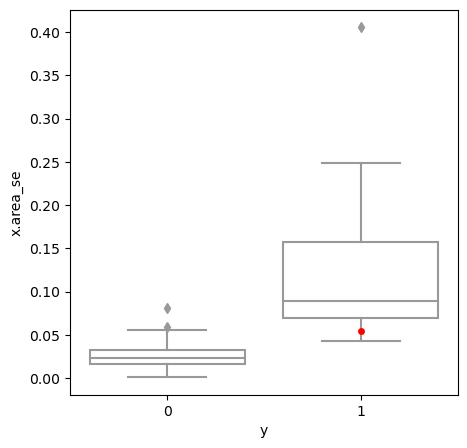

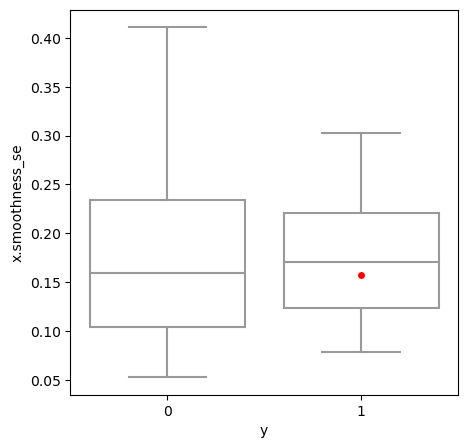

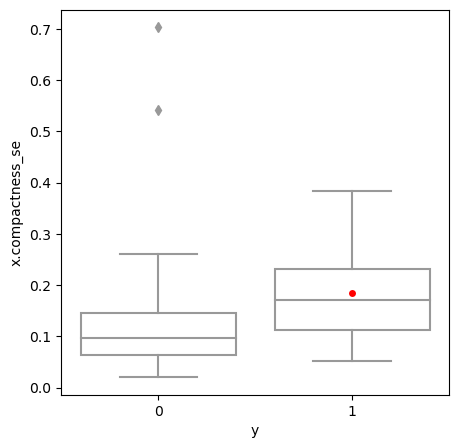

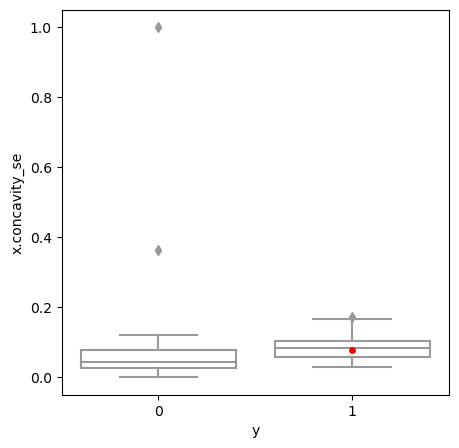

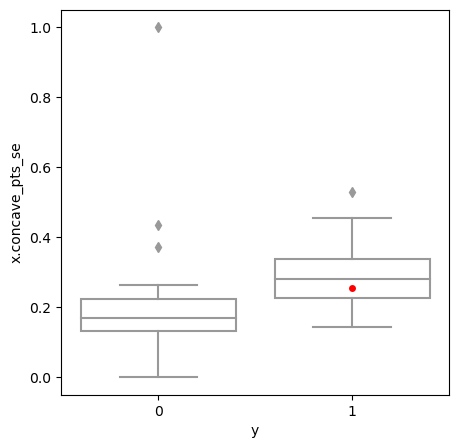

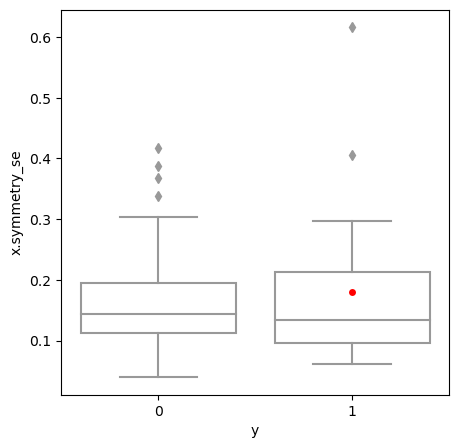

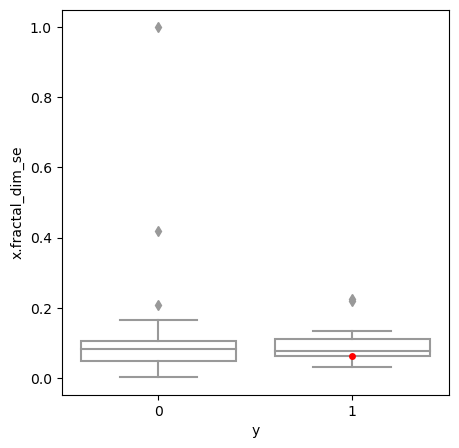

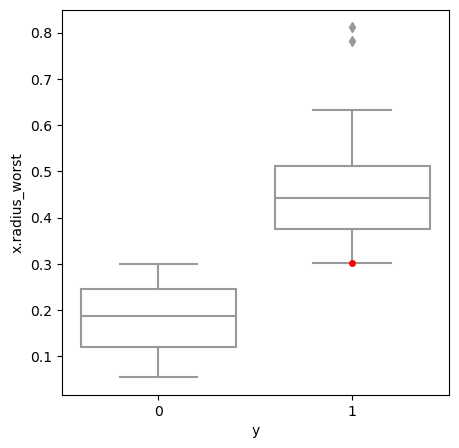

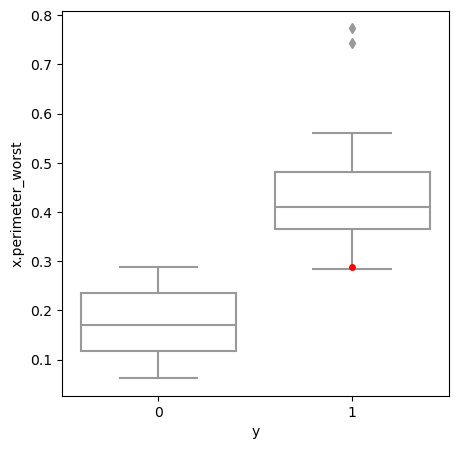

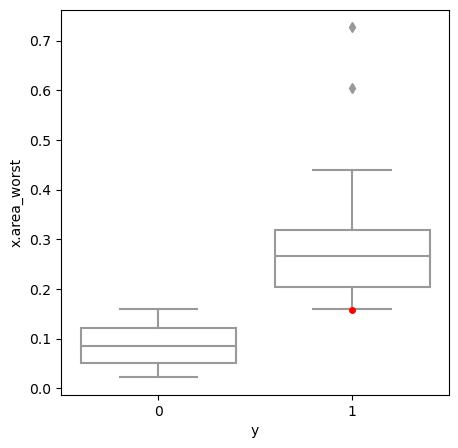

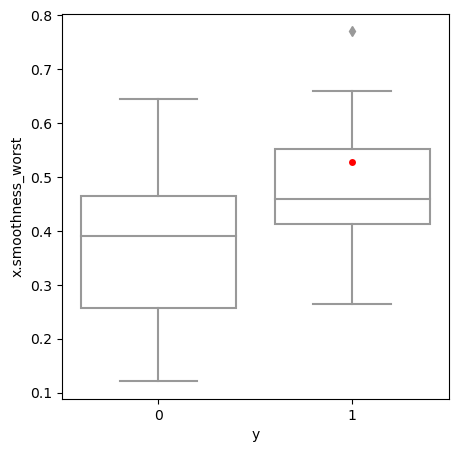

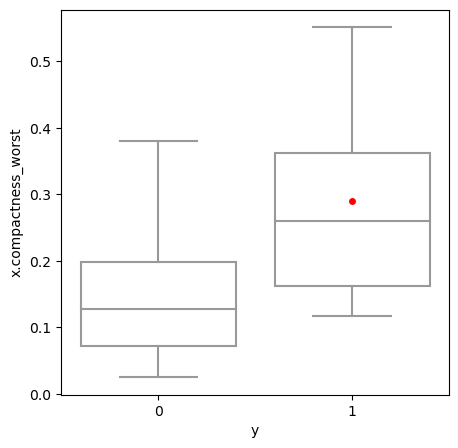

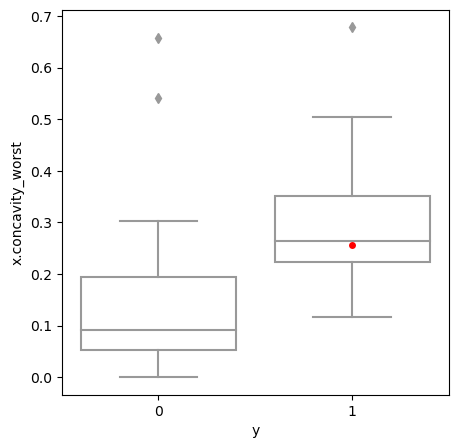

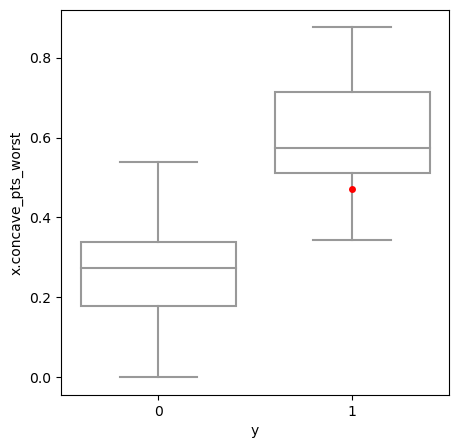

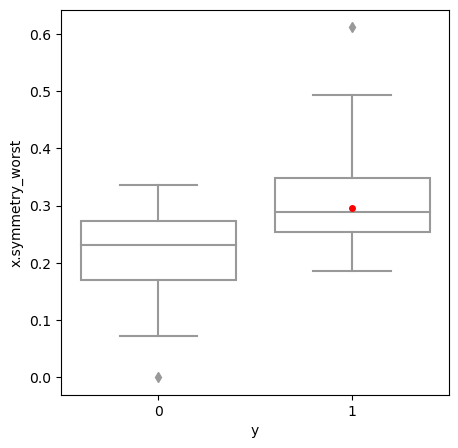

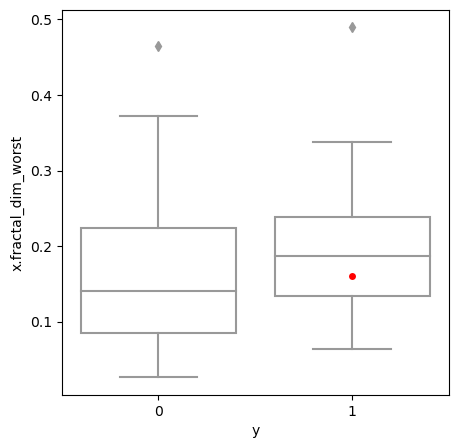

In [36]:
for col in predict_df.columns:
    if str(col).count('x') > 1 or col in ['prediction_status','y','predict','predict_sig']:
        continue
    fig, axes = plt.subplots(figsize=(5,5))
    sns.boxplot(data=predict_df[predict_df["prediction_status"]=="Right"], y=col, x="y", color="white", order=[0,1])
    sns.stripplot(data=predict_df[predict_df["prediction_status"]=="Wrong"], y=col, x="y", color="red", order=[0,1])